# Predicting inclinations from magnetic maps using convolutional neural networks (CNNs)

Training a CNN predictor that can predict inclinations of the magnetization of a source body in the subsurface, given a magnetic data map. 
<br>


## What is inclination?

The Earth's magnetic field can be represented by a three-dimensional vector. A typical procedure for measuring its direction is to use a compass to determine the direction of magnetic North. Its angle relative to true North is the declination (D) or variation. Facing magnetic North, the angle the field makes with the horizontal is the inclination (I) or magnetic dip. The intensity (F) of the field is proportional to the force it exerts on a magnet.

<img src = "https://drive.google.com/uc?id=1-IJX4-gJRTmkxgP-diI5p0pndLIPJPf1" width = "600">


## 1. Import Packages

In [2]:
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, BatchNormalization, Activation
from keras.utils import to_categorical
# from keras.models import MaxPooling2D

import matplotlib.pyplot as plt 
import tensorflow as tf
import pandas as pd

# Supress tensorflow warnings as I am only running CPU
TF_CPP_MIN_LOG_LEVEL="2"

## 2. Load Data

In [3]:
X = np.load("./XMagneticDataMaps.npy","r")
Y = np.load("./YMagneticDataMaps.npy", "r")

In [4]:
X.shape

(4140, 29, 29, 1)

In [5]:
Y[:10]

memmap([[15.],
        [17.],
        [ 4.],
        [ 1.],
        [ 7.],
        [10.],
        [ 6.],
        [ 8.],
        [14.],
        [ 5.]])

Note that **X** contains 4140 magnetic data maps, each of which is a 29 X 29 map. And **Y** contains 4140 labels, each of which corresponds to one data map in **X**.

**Note**: These training images were generated assuming the ambient inducing field is 50000 nT, and I=-65, D=8, susceptibility is 0.2, depth of the source body is 100m-200m. Also the angle increments for the forward-modeled datamaps were decreased from every 2 degrees to 4 degrees so that the data maps are not too large to be processed in Google Colab.

In [7]:
# Create a dictionary that connects each label to a unique inclination range
IncDict = np.load("./InclinationDictionary.npy", "r")
Inc = {}
for i in range(len(IncDict)):
    Inc[IncDict[i,0]] = IncDict[i,1]

In [8]:
# conver integer category to inclination
def cat_to_inc(Y):
    return(Inc[str(int(Y))])

## 3. Data preprocessing

In [9]:
# Simple preprocessing 
# normalize each data type of the maximum value
X = X/np.max(X)

## 4. Visualize Data

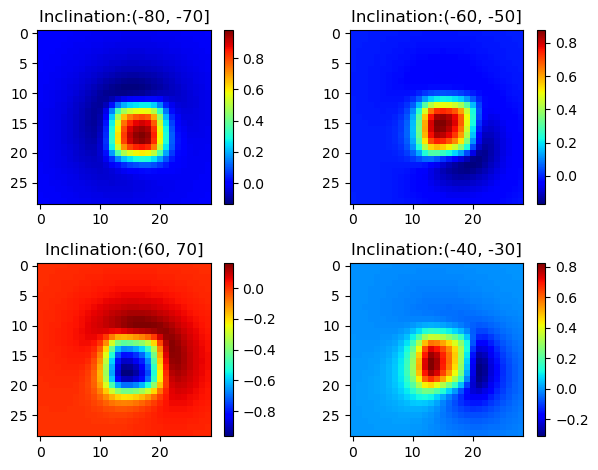

In [10]:
randnum = np.random.randint(0,4140,4)
for i in np.arange(4):
    plt.subplot(2,2,i+1)
    plt.imshow(X[randnum[i]].reshape((29,29)), cmap = 'jet')
    plt.colorbar()
    plt.title("Inclination:" + cat_to_inc(Y[randnum[i]]))
plt.tight_layout()      
plt.show()

Notice that, the spatial patterns of the magnetic data anomalies depend upon the inclinations. In other words, there is a relationship between inclination (of magnetization) and spatial patterns (of magnetic anomalies shown in a data map). I am going to train a CNN to learn this relationship. Once the learning is finished, I will be able to predict the inclination, given a magnetic data map.

## 5. Prepare training, validation and test data

In [11]:
X_train = X[0:int(len(X)*0.6)]
X_val = X[int(len(X)*0.6):int(len(X)*0.6) + int(len(X)*0.2)]
X_test = X[int(len(X)*0.6) + int(len(X)*0.2): -1]

Y_train = to_categorical(Y[0:int(len(X)*0.6)])
Y_val = to_categorical(Y[int(len(X)*0.6):int(len(X)*0.6) + int(len(X)*0.2)])
Y_test = to_categorical(Y[int(len(X)*0.6) + int(len(X)*0.2): -1])

The <font color=red>**training data**</font> and the corresponding labels are, respectively, <font color=blue>**X_train**</font> and <font color=blue>**Y_train**</font>. <br>
The <font color=red>**validation data**</font> and the corresponding labels are, respectively, <font color=blue>**X_val**</font> and <font color=blue>**Y_val**</font>. <br>
The <font color=red>**test data**</font> and the corresponding labels are, respectively, <font color=blue>**X_test**</font> and <font color=blue>**Y_test**</font>.

## 6. Build and train your CNNs

Create and train a CNN.  <br>

**Hint**: Because it is a multi-class problem here,  use `softmax` as the activation for the output layer. There are 18 possible classes to predict and should have 18 neurons in your last layer. 

In [12]:
model = Sequential()
# Add layers
model.add(Conv2D(32, 
          kernel_size=(3,3),
          strides=1, 
          padding="same",
          input_shape=(29,29,1), 
          activation="relu"))
model.add(Conv2D(32, 
          (3,3), 
          padding="same", 
          activation="relu"))
model.add(Flatten())
model.add(Dense(26,
          activation='relu'))
model.add(Dense(18, 
          activation="softmax"))


# Compile the model
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

# Fit the model
history = model.fit(X_train, 
                    Y_train, 
                    batch_size=128,
                    epochs=15, 
                    verbose=1, 
                    validation_data=(X_test, Y_test))  
# Evaluate score
score = model.evaluate(X_test, 
                       Y_test,
                       verbose=0)

2022-11-15 14:54:14.668394: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-15 14:54:14.668410: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-15 14:54:14.668424: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (crumblerworm): /proc/driver/nvidia/version does not exist
2022-11-15 14:54:14.668580: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/15
20/20 [==============================] - 1s 43ms/step - loss: 2.3355 - accuracy: 0.2110 - val_loss: 1.9167 - val_accuracy: 0.2527
Epoch 2/15
20/20 [==============================] - 1s 39ms/step - loss: 1.6726 - accuracy: 0.4412 - val_loss: 1.4856 - val_accuracy: 0.5175
Epoch 3/15
20/20 [==============================] - 1s 40ms/step - loss: 1.2098 - accuracy: 0.5717 - val_loss: 1.0490 - val_accuracy: 0.5345
Epoch 4/15
20/20 [==============================] - 1s 42ms/step - loss: 0.8992 - accuracy: 0.6365 - val_loss: 0.7297 - val_accuracy: 0.7074
Epoch 5/15
20/20 [==============================] - 1s 42ms/step - loss: 0.6862 - accuracy: 0.7295 - val_loss: 0.6695 - val_accuracy: 0.7521
Epoch 6/15
20/20 [==============================] - 1s 41ms/step - loss: 0.4892 - accuracy: 0.8245 - val_loss: 0.4600 - val_accuracy: 0.8295
Epoch 7/15
20/20 [==============================] - 1s 41ms/step - loss: 0.4165 - accuracy: 0.8498 - val_loss: 0.4968 - val_accuracy: 0.7956
Epoch 8/15
20

## 7. Check learning curves

Plot the learning curves (i.e., curves of the training loss, training accuracy, validation loss and validation accuracy).  <br>



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 29, 29, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 flatten (Flatten)           (None, 26912)             0         
                                                                 
 dense (Dense)               (None, 26)                699738    
                                                                 
 dense_1 (Dense)             (None, 18)                486       
                                                                 
Total params: 709,792
Trainable params: 709,792
Non-trainable params: 0
_________________________________________________________________


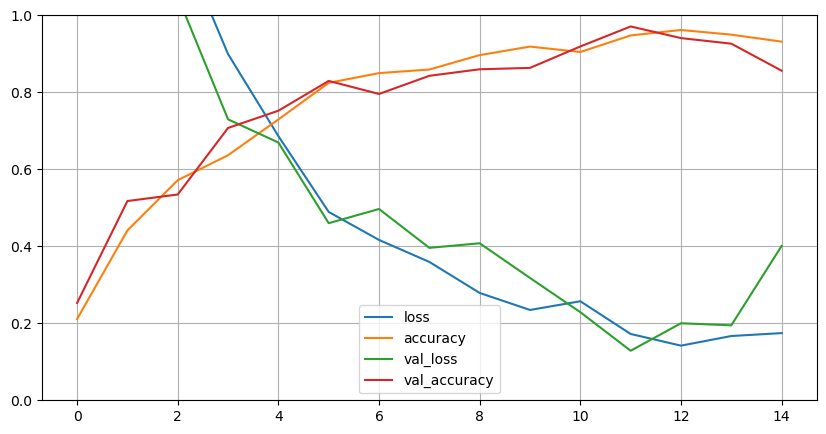

In [13]:
model.summary()

pd.DataFrame(history.history).plot(figsize=(10,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

## 8. Check the accuracies on test data maps

Evaluate the model using test data.  <br>



In [14]:
# Model accuracy
acc1 = model.evaluate(X_test,Y_test)
acc2 = model.evaluate(X_train,Y_train)
acc3 = model.evaluate(X_val,Y_val)       
print('training/test acurracy difference: %0.2f'%((acc2[1]-acc1[1])*100) + '%')
print('training/validation acurracy difference: %0.2f'%((acc2[1]-acc3[1])*100) + '%')
print('validation/test accuracy difference: %0.2f'%((acc3[1] - acc1[1])*100) + '%')



26/26 [==============================] - 0s 4ms/step - loss: 0.3971 - accuracy: 0.8478
training/test acurracy difference: 2.55%
training/validation acurracy difference: 3.38%
validation/test accuracy difference: -0.83%


## 9. Make predictions on synthetic test data maps

1/1 [==============================] - 0s 51ms/step


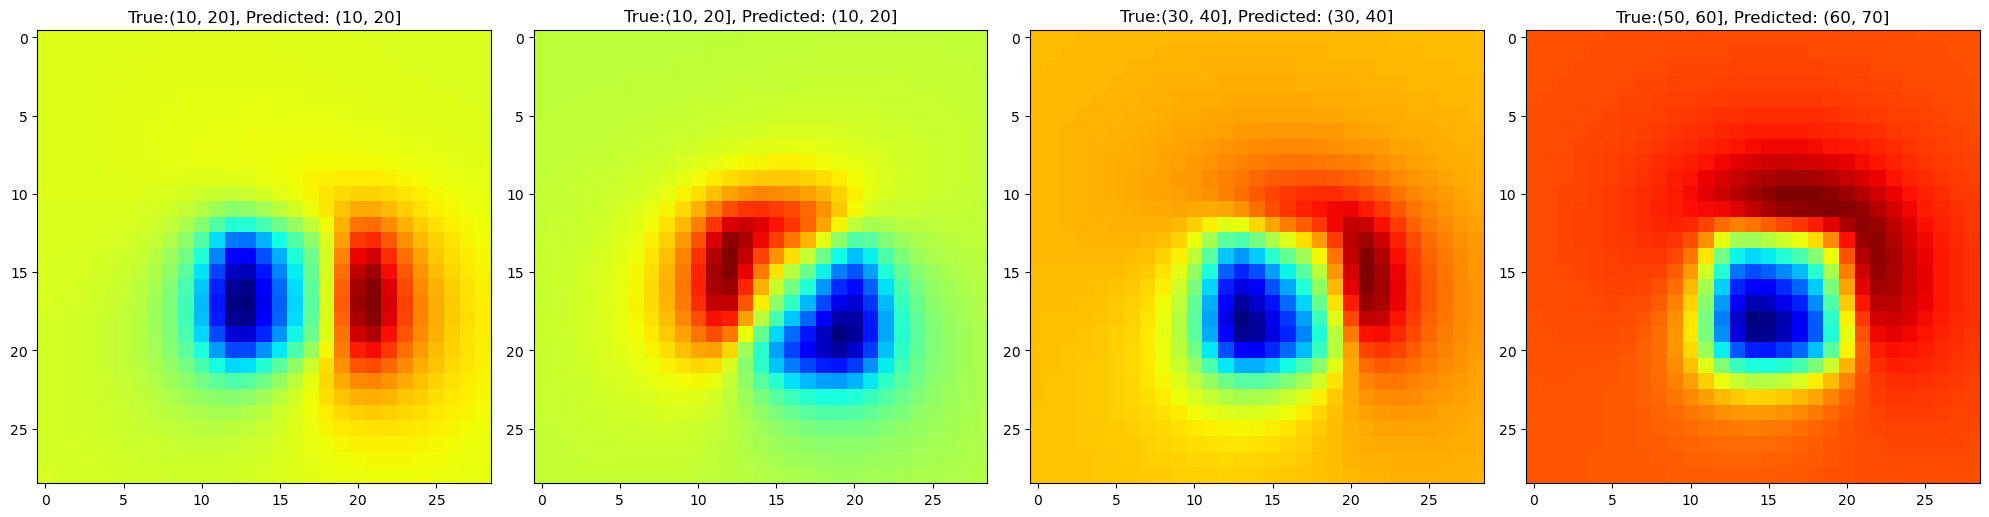

In [15]:
n = 420
Xpred = X_test[n:n+4]
Ytrue = Y_test[n:n+4]
Ypred = model.predict(Xpred)
plt.figure(figsize=(20,20))


for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(Xpred[i].reshape(29,29), cmap="jet")
    plt.title("True:" + cat_to_inc(np.argmax(Ytrue[i])) + ", Predicted: " + cat_to_inc(np.argmax(Ypred[i])))

plt.tight_layout()
plt.show()

### Summary


The predicted values and the true values match, although they do miss in some iterations, which is to be expected without 100% accuracy. The plots themselves resemble the magnetic anomalies shown at the start of the script.

## 10. Make predictions on field data

Let us apply the CNN that you trained above to field data!!! 

The field data comes from an area in Australia called Black Hill Norite close to the City of Adelaide. Preivous studies show that these norites formed from a mafic intrusion of the Ordovician period.


Geoloy 101: Norite is a mafic intrusive igneous rock composed largely of the calcium-rich plagioclase labradorite, orthopyroxene, and olivine. The name norite is derived from Norge, the Norwegian name for Norway. Norite also known as orthopyroxene gabbro (https://en.wikipedia.org/wiki/Norite). Here is a picture of norite.

<img src = "https://drive.google.com/uc?id=1j_kpdMFM6BmmJQRzPPmOIsvpIGhY0kmJ" width = "300">

The magnetic data measured over this area is shown below (left). We observe strong magnetic anomalies resulting from the norite intrusions. This will focus on the anomalies located in the northwest region, which are shown below (right).

<img src = "https://drive.google.com/uc?id=1A8NmHyxM1CZ6acqhswX9cjfHo9EmCX5S" width = "500">

<img src = "https://drive.google.com/uc?id=1TJRzFz0Uv8yVLGfltkq6RZEd_ENgl3WJ" width = "500">


### 10.1 Read the magnetic data 

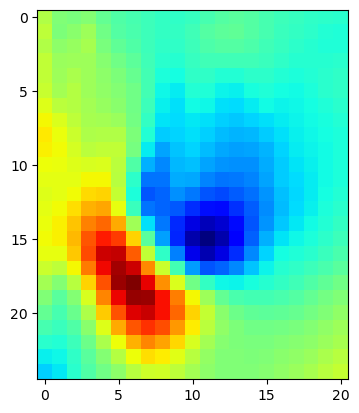

In [16]:
count = 0
i=0
data = np.zeros(int(21*25))
with open('./obs_BlackHill2.mag') as f:
    for line in f:
        arr = line.split()
        if i> 1:
            data[count] = arr[3]
            count+=1
        i+=1
data2d = np.reshape(data,(25,21))
plt.imshow(data2d,cmap='jet')

data2d_normalize = np.reshape(data2d, (1,25,21,1))/np.max(data2d)


### 10.2 Make prediction

In [17]:
field_data_resized = tf.image.resize(data2d_normalize,[29,29])

 Apply the CNN trained above to the field data `field_data_resized`.

In [18]:
y_pred = model.predict(field_data_resized)

1/1 [==============================] - 0s 15ms/step


In [19]:
print('The predicted inclination is:',cat_to_inc(np.argmax(y_pred)))


The predicted inclination is: (-10, 0]


## 11. Application of CNN to geoscientific and atmospheric problems

______________________________________________________

## [Convolutional Neural Network for Multipath Detection in GNSS Receivers](https://arxiv.org/abs/1911.02347#:~:text=Convolutional%20Neural%20Network%20for%20Multipath%20Detection%20in%20GNSS%20Receivers,-Evgenii%20Munin%2C%20Antoine&text=This%20work%20explores%20the%20application,of%20the%20correlator%20output%20signal.)


Global Navigational Satellite System (GNSS) signal error is heavily influenced by multipath error, which effects the accuracy of calculating GPS positioning. To better understand how to mitigate multipath error the authors have developed a CNN model to train and extract important features in the L1 C/A signal from GNSS satellites. 

The way they do this is by generating synthetic GNSS labeled data for prediction testing. They then construct a training dataset represented in the form of 3D tensors that is balanced between two classes, category A and category B, which distinguish between signals with multipath (i.e. doppler shift, code delay, or phase offsets) and not multipath (i.e. only direct signal). Lastly, they go on to run a range of experiments using different CNN architectures.

The conlusion is that the proposed method of using CNN to detect multipath in GNSS signals has been validated with the synthetic GPS data generated using their GPS data generator. The preformance of this method is on par with current SVM (Support Vector Machine) classifier based methods and a viable method for multipath detection and subsequent mitigation.


________________________________________________________________________________
[Rapid prediction of earthquake ground shaking intensity using raw
waveform data and a convolutional neural network](https://academic.oup.com/gji/article/222/2/1379/5836721)


The motivation for this paper is to further the science of rapid earthquake assessment to enhance earthquake monitering. Post-earthquake rapid analysis is critical to disaster response efforts. Using waveform data and CNN analysis, the authors aim to improve upon current EEW (early earthquake warning) systems already in place.

The authors of this study use a CNN based method to predict the intensity measurements (IMs) of earthquake ground shaking through the use of raw waveform data. The input of their CNN model was a multistation, 3C acceleration waveform that was recorded during the 2016 Central Italy earthquake. They found that by using waveform training data from 39 stations from a set of 915 earthquakes with a $M \geq 3.0$ and 1037 only noise examples, during a 10 s window, beginning at the orgin of the earthquake, the CNN could accurately predict the IMs at stations far from the acutal epicenter, at stations that had not yet recorded the maximum ground shaking. An interesting feature of this paper is the CNN IM predictions do not require knowledge of the eathquake source (i.e. location and magnitude). 



